In [1]:
import torchvision
import torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

In [11]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

Saving IMG_6041.JPG to IMG_6041.JPG
kaggle.json


In [13]:
#!kaggle datasets download -d tongpython/cat-and-dog
#!unzip cat-and-dog.zip
!kaggle datasets download -d iiplutocrat45ii/painting-vs-photograph-classification-dataset
!unzip painting-vs-photograph-classification-dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: train/photos/94c54a8fcc7cb14074ac10a5ef6e298149b8c007.jpg  
  inflating: train/photos/94e1bd10bf9907516c0294e1727e1a5972c84366.jpg  
  inflating: train/photos/94f513b161445c2f22f892a7779ae45430ce3d18.jpg  
  inflating: train/photos/94f792a9ad417f11e3aa0b81c2cd169164d56968.jpg  
  inflating: train/photos/94fdaa407e1c70ba174386c78a09c144f7ae9047.jpg  
  inflating: train/photos/950ec8ecccc507bd9f1b43a1404463869edb77f4.jpg  
  inflating: train/photos/9524e0e16c6beb7f5b269ac7d71119e9c8c33911.jpg  
  inflating: train/photos/9528139eeacb163e1fd3c137c3a256c22ac35922.jpg  
  inflating: train/photos/953b557dce5782f4895bc38a715390ec040b154a.jpg  
  inflating: train/photos/95459b5d59475416ced7328590257ec5eb507f96.jpg  
  inflating: train/photos/954f04f1c988bbd2f372ae13ab739f465b5462b7.jpg  
  inflating: train/photos/961b595b676ad5f97b9a3528f3bf0e4a2963a538.jpg  
  inflating: train/photos/961c529e786a0763ff4a76f93113ffaa8dcce14b.jpg  
  inflating: tr

In [15]:
train_data_dir = 'train/'
valid_data_dir = 'valid/'
test_data_dir = 'test/'

In [16]:
import os

class PhotosPainting(Dataset):
    def __init__(self, folder, num_images = 1500):
        # 아래의 코드를 완성하세요.
        photos = glob(os.path.join(folder, 'photo', '*.jpg'))# photo images 경로 설정
        painting = glob(os.path.join(folder, 'painting', '*.jpg'))# painting images 경로 설정
        self.fpaths = photos[:num_images] + painting[:num_images]
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        from random import shuffle, seed; seed(10); shuffle(self.fpaths)
        # 아래의 코드를 완성하세요.
        self.targets = [0 if 'photo' in f else 1 for f in self.fpaths]# photo and painting images의 label (true/false) 설정
    def __len__(self): return len(self.fpaths)
    def __getitem__(self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        im = torch.tensor(im/255)
        im = im.permute(2,0,1)
        im = self.normalize(im) 
        return im.float().to(device), torch.tensor([target]).float().to(device)

        

In [17]:
data = PhotosPainting(train_data_dir)

tensor([1.], device='cuda:0')


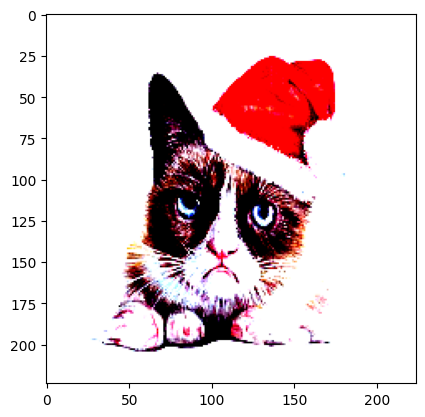

In [18]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [20]:
def get_model():
    model = models.vgg16(pretrained=True)
    # Hint: print(model)로 model 구조를 출력하고 layer의 number를 확인해보시오.
    # 아래의 코드를  완성하시오.
    print(model)
    #
    for param in model.parameters():
      param.requires_grad = False
    #
    # 
    # 

    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128, 1),
    nn.Sigmoid())
    loss_fn = nn.BCELoss()

      
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

In [21]:
!pip install torch_summary
from torchsummary import summary
model, criterion, optimizer = get_model()
summary(model, torch.zeros(1,3,224,224))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 245MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [22]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

In [23]:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    is_correct = (prediction > 0.5) == y
    return is_correct.cpu().numpy().tolist()

In [24]:
def get_data():
    train = PhotosPainting(train_data_dir, num_images = 3000)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last = True)
    val = PhotosPainting(valid_data_dir, num_images = 1500)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)
    return trn_dl, val_dl

In [26]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [27]:
train_losses, train_accuracies = [], []
val_accuracies = []
num_epoch = 10
for epoch in range(num_epoch):
    #print(f" epoch {epoch + 1}/{num_epoch}")
    train_epoch_losses, train_epoch_accuracies = [], []
    val_epoch_accuracies = []

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss) 
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_epoch_accuracies.extend(val_is_correct)
    val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

    print(f"epoch {epoch + 1}/{num_epoch}, train_epoch_loss:{train_epoch_loss}, train_epoch_accuracy: {train_epoch_accuracy}, val_epoch_accuracy: {val_epoch_accuracy}")
    

epoch 1/10, train_epoch_loss:0.02971679962181326, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 2/10, train_epoch_loss:0.000533860047751229, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 3/10, train_epoch_loss:0.00028132069017237395, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 4/10, train_epoch_loss:0.0001544209314576414, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 5/10, train_epoch_loss:0.00011154999640805932, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 6/10, train_epoch_loss:8.496398411670691e-05, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 7/10, train_epoch_loss:5.32813475169322e-05, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 8/10, train_epoch_loss:4.533430540575825e-05, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 9/10, train_epoch_loss:4.4086788495396144e-05, train_epoch_accuracy: 1.0, val_epoch_accuracy: 1.0
epoch 10/10, train_epoch_loss:3.6234050940625056e-05, train_epoch_accuracy

<ipython-input-28-e45db125c4a3>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


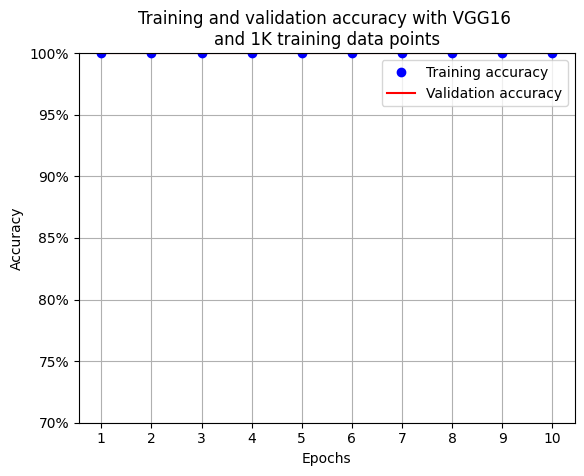

In [28]:
epochs = np.arange(num_epoch)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with VGG16 \nand 1K training data points')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.95,1)
plt.ylim(0.7,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [29]:
print(train_accuracies)


[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [30]:
print(val_accuracies)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
